## Library & Spark Builder

In [ ]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=6b824e0116ca8cbaad99aadde5583d4c7b309bd9ac15d8e4cbdba2e3a91ecb86
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col, count, when, isnan, mean
from pyspark.sql.types import FloatType
from sklearn.cluster import KMeans
from pyspark.sql.functions import col, regexp_replace
from pyspark.sql.types import FloatType, DoubleType
from pyspark.sql.functions import lit, mean
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Inisialisasi SparkSession
spark = SparkSession.builder \
    .appName("Energy Usage Clustering") \
    .getOrCreate()

## Dataset

In [ ]:
# Membaca dataset
df = spark.read.csv("/content/data_tubes_2.csv", header=True,sep=';', inferSchema=True)
df.show(5)

+----------+-------------------+-------------------+---------------------+-------+----------------+--------------+--------------+--------------+
|      Date|               Time|Global_active_power|Global_reactive_power|Voltage|Global_intensity|Sub_metering_1|Sub_metering_2|Sub_metering_3|
+----------+-------------------+-------------------+---------------------+-------+----------------+--------------+--------------+--------------+
|16/12/2006|2024-05-27 17:24:00|              4.216|                0.418|234.840|          18.400|         0.000|         1.000|          17.0|
|16/12/2006|2024-05-27 17:25:00|              5.360|                0.436|233.630|          23.000|         0.000|         1.000|          16.0|
|16/12/2006|2024-05-27 17:26:00|              5.374|                0.498|233.290|          23.000|         0.000|         2.000|          17.0|
|16/12/2006|2024-05-27 17:27:00|              5.388|                0.502|233.740|          23.000|         0.000|         1.000| 

In [ ]:
df.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Time: timestamp (nullable = true)
 |-- Global_active_power: string (nullable = true)
 |-- Global_reactive_power: string (nullable = true)
 |-- Voltage: string (nullable = true)
 |-- Global_intensity: string (nullable = true)
 |-- Sub_metering_1: string (nullable = true)
 |-- Sub_metering_2: string (nullable = true)
 |-- Sub_metering_3: double (nullable = true)



## Code K-Means Cluster

In [ ]:
df = df.withColumn('Sub_metering_1', col('Sub_metering_1').cast(FloatType()))
df = df.withColumn('Sub_metering_2', col('Sub_metering_2').cast(FloatType()))
df = df.withColumn('Sub_metering_3', col('Sub_metering_3').cast(FloatType()))

In [ ]:
# Pilih kolom yang ingin diperiksa
selected_columns = ["Sub_metering_1", "Sub_metering_2", "Sub_metering_3"]
df = df[selected_columns]

# Memeriksa jumlah nilai hilang per kolom yang dipilih
missing_counts_selected = [count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in selected_columns]
df.agg(*missing_counts_selected).show()

+--------------+--------------+--------------+
|Sub_metering_1|Sub_metering_2|Sub_metering_3|
+--------------+--------------+--------------+
|          4069|          4069|          4069|
+--------------+--------------+--------------+



In [ ]:
# Menghitung nilai rata-rata dari setiap kolom yang dipilih
mean_values = df.agg(*(mean(col(c)).alias(c) for c in selected_columns))

# Mengambil nilai rata-rata sebagai dictionary
mean_dict = mean_values.first().asDict()

# Mengisi nilai kosong dengan nilai rata-rata
df= df.fillna(mean_dict)
df.agg(*missing_counts_selected).show()

+--------------+--------------+--------------+
|Sub_metering_1|Sub_metering_2|Sub_metering_3|
+--------------+--------------+--------------+
|             0|             0|             0|
+--------------+--------------+--------------+



In [ ]:
# Memilih fitur-fitur yang akan digunakan untuk klastering
feature_cols = ["Sub_metering_1", "Sub_metering_2", "Sub_metering_3"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data = assembler.transform(df)
data.show()

+--------------+--------------+--------------+--------------+
|Sub_metering_1|Sub_metering_2|Sub_metering_3|      features|
+--------------+--------------+--------------+--------------+
|           0.0|           1.0|          17.0|[0.0,1.0,17.0]|
|           0.0|           1.0|          16.0|[0.0,1.0,16.0]|
|           0.0|           2.0|          17.0|[0.0,2.0,17.0]|
|           0.0|           1.0|          17.0|[0.0,1.0,17.0]|
|           0.0|           1.0|          17.0|[0.0,1.0,17.0]|
|           0.0|           2.0|          17.0|[0.0,2.0,17.0]|
|           0.0|           1.0|          17.0|[0.0,1.0,17.0]|
|           0.0|           1.0|          17.0|[0.0,1.0,17.0]|
|           0.0|           1.0|          17.0|[0.0,1.0,17.0]|
|           0.0|           2.0|          16.0|[0.0,2.0,16.0]|
|           0.0|           1.0|          17.0|[0.0,1.0,17.0]|
|           0.0|           1.0|          17.0|[0.0,1.0,17.0]|
|           0.0|           1.0|          16.0|[0.0,1.0,16.0]|
|       

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

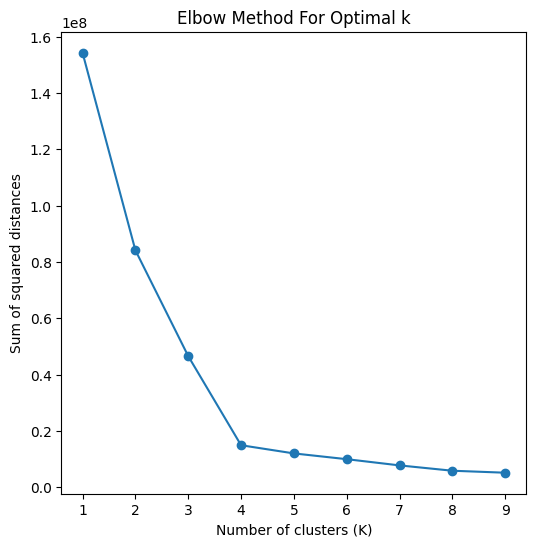

In [ ]:
# Convert PySpark DataFrame to Pandas DataFrame and then to NumPy array
pandas_df = data.select("features").toPandas()
list_data = np.array(pandas_df["features"].tolist())

# KMeans clustering and elbow method
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k, max_iter=100)
    km.fit(list_data)
    sse.append(km.inertia_)

# Plot SSE against number of clusters
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
# Run KMeans with optimal number of clusters (e.g., k=3)
k = 3
km = KMeans(n_clusters=k, max_iter=100)
km.fit(list_data)
centroids = km.cluster_centers_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
from pyspark.ml.clustering import KMeans

# jumlah klaster
k = 3

# Melatih model KMeans
kmeans = KMeans().setK(k).setSeed(1)
model = kmeans.fit(data)

# Mendapatkan hasil klastering
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

# Menambahkan prediksi klaster ke DataFrame asli
predictions = model.transform(data)
predictions.show()

Cluster Centers: 
[0.60644932 0.40417119 0.26722586]
[ 2.18255066  0.49945946 17.55722148]
[ 3.36820389 35.06604881 10.68403847]
+--------------+--------------+--------------+--------------+----------+
|Sub_metering_1|Sub_metering_2|Sub_metering_3|      features|prediction|
+--------------+--------------+--------------+--------------+----------+
|           0.0|           1.0|          17.0|[0.0,1.0,17.0]|         1|
|           0.0|           1.0|          16.0|[0.0,1.0,16.0]|         1|
|           0.0|           2.0|          17.0|[0.0,2.0,17.0]|         1|
|           0.0|           1.0|          17.0|[0.0,1.0,17.0]|         1|
|           0.0|           1.0|          17.0|[0.0,1.0,17.0]|         1|
|           0.0|           2.0|          17.0|[0.0,2.0,17.0]|         1|
|           0.0|           1.0|          17.0|[0.0,1.0,17.0]|         1|
|           0.0|           1.0|          17.0|[0.0,1.0,17.0]|         1|
|           0.0|           1.0|          17.0|[0.0,1.0,17.0]|       

## Visualisasi K-Means

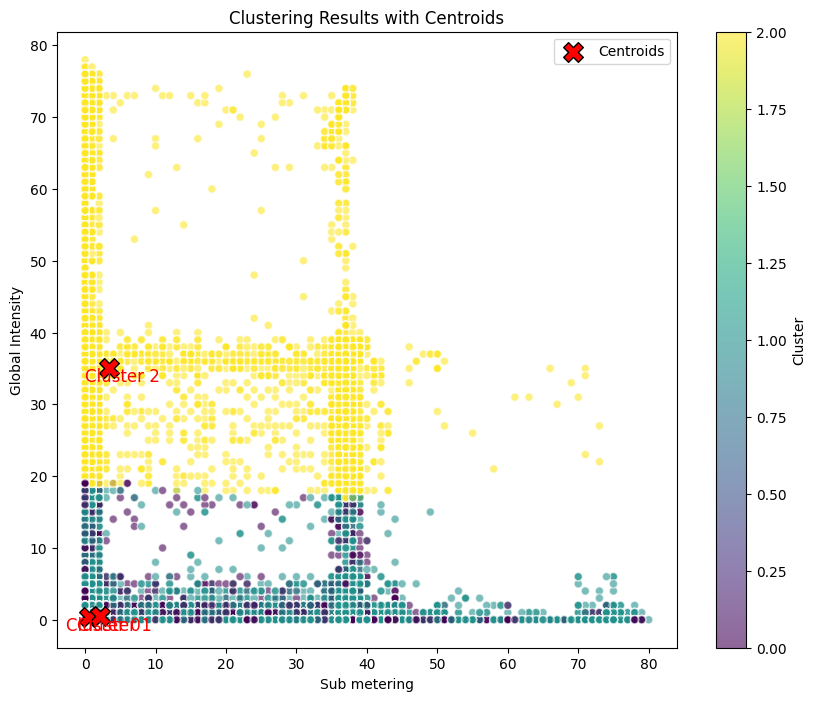

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
# Ambil hasil klaster dari DataFrame predictions
cluster_results = predictions.select("Sub_metering_1", "Sub_metering_2", "Sub_metering_3", "prediction")

# Konversi ke Pandas DataFrame untuk visualisasi
cluster_results_pd = cluster_results.toPandas()

# Plot scatter plot dari hasil klaster
plt.figure(figsize=(10, 8))
scatter = plt.scatter(cluster_results_pd['Sub_metering_1'], cluster_results_pd['Sub_metering_2'], c=cluster_results_pd['prediction'], cmap='viridis', alpha=0.6, edgecolors='w')

# Menambahkan centroids ke plot
centers = model.clusterCenters()
centers_pd = pd.DataFrame(centers, columns=["Sub_metering_1", "Sub_metering_2", "Sub_metering_3"])

plt.scatter(centers_pd["Sub_metering_1"], centers_pd["Sub_metering_2"], c='red', marker='X', s=200, edgecolor='k', label='Centroids')

# Menambahkan keterangan jumlah cluster
for i, center in enumerate(centers):
    plt.annotate(f'Cluster {i}', (center[0], center[1]), textcoords='offset points', xytext=(10,-10), ha='center', color='red', fontsize=12)

plt.xlabel('Sub metering')
plt.ylabel('Global Intensity')
plt.title('Clustering Results with Centroids')
plt.legend()
plt.colorbar(scatter, label='Cluster')
plt.show()

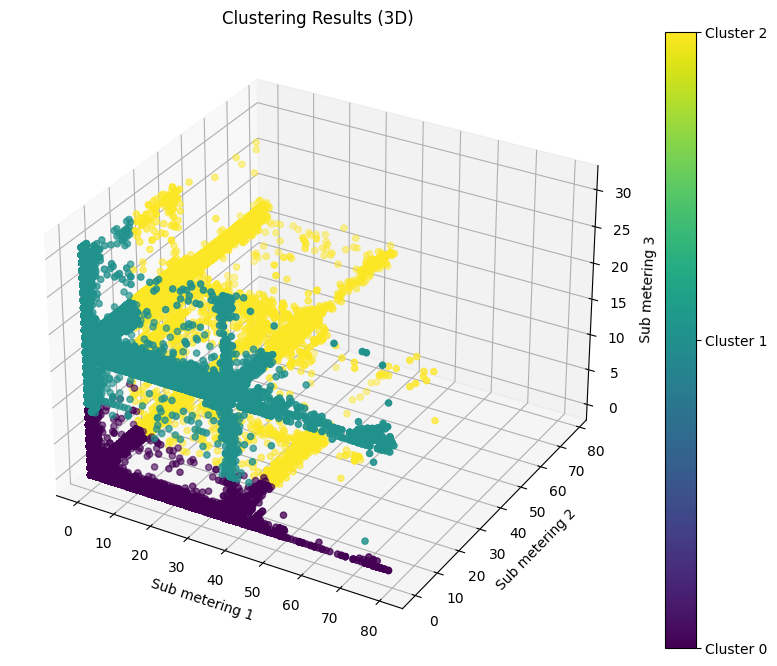

In [ ]:
# Buat figure 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot scatter plot 3D dari hasil klaster
scatter = ax.scatter(cluster_results_pd['Sub_metering_1'], cluster_results_pd['Sub_metering_2'], cluster_results_pd['Sub_metering_3'], c=cluster_results_pd['prediction'], cmap='viridis')

# Atur label sumbu dan judul
ax.set_xlabel('Sub metering 1')
ax.set_ylabel('Sub metering 2')
ax.set_zlabel('Sub metering 3')
ax.set_title('Clustering Results (3D)')

# Tambahkan colorbar untuk menampilkan skala warna
cbar = fig.colorbar(scatter, ax=ax, ticks=[0, 1, 2])
cbar.ax.set_yticklabels(['Cluster 0', 'Cluster 1', 'Cluster 2'])  # Ganti label sesuai dengan jumlah cluster

# Tampilkan plot
plt.show()